In [1]:
# Mandatorio al inicio de cada notebook
import os
import warnings
os.chdir(os.path.abspath(".."))
warnings.filterwarnings('ignore')

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.traductores import emocion_ekman
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization

### Input Data

In [3]:
df_input = pd.read_csv(f'data/FEATURES/OPENSMILE/opensmile_features_whisper.csv')

In [4]:
# Fix para la diferencia en como estan estos valores, debo arreglarlo a futuro en el archivo de features opensmile
df_input['Time'] = df_input['Time'].str.replace('(','[').str.replace(')',']')

### Target Data

In [5]:
# Obtenemos el json con los intervalos
with open('data/objetivos_por_voto_promedio_whisper.json', 'r') as f:
    targets_mean_vote = json.load(f)

In [6]:
# Loop principal para obtener los tiempos y target en pandas
df_ranges = pd.DataFrame()

for _key in targets_mean_vote.keys():

    X = []
    for segment, target, indice in zip(targets_mean_vote[_key]['rangos'], targets_mean_vote[_key]['targets'], targets_mean_vote[_key]['indice']):
        x = []
        x.append(segment)
        x.append(target)
        x.append(indice)
        X.append(x)
        
    df = pd.DataFrame(X, columns = ['Time','Target','Indice'])
    df['Audio_Name'] = _key
    df_ranges = pd.concat([df_ranges, df], ignore_index = True)
    
df_ranges.head()

,Time,Target,Indice,Audio_Name
0,"[3.46, 5.239999999999999]","[22.434153132250582, 25.742998839907195, 27.96...",1,MSP-Conversation_0021.wav
1,"[5.22, 8.36]","[24.9327970320278, 28.68542406311637, 29.61763...",2,MSP-Conversation_0021.wav
2,"[8.26, 11.04]","[26.283004629131234, 34.07772544586788, 32.202...",3,MSP-Conversation_0021.wav
3,"[11.32, 12.44]","[27.692511860832894, 31.18817035670357, 30.649...",4,MSP-Conversation_0021.wav
4,"[13.48, 16.76]","[16.63573400250941, 12.879463613550815, 12.705...",5,MSP-Conversation_0021.wav


In [7]:
print(len(df_input))
print(len(df_ranges))

71378
71378


In [8]:
# Join para obtener dataset final
df_ranges['Time'] = df_ranges['Time'].astype(str) 
df_final = pd.merge(df_input, df_ranges, how = 'inner', left_on = ['Indice','Audio_Name'], right_on = ['Indice','Audio_Name']).drop(['Time_x','Time_y'], axis = 1)

In [9]:
df_final.head()

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,Audio_Name,Indice,Target
0,1.498477,0.000000,0.714286,0.485805,0.701391,0.962348,0.215586,0.260957,0.476543,0.362370,...,1.451927,-10.622149,0.404903,85.88666,25.218460,80.42445,24.244904,MSP-Conversation_2281.wav,1036,"[10.491853582554517, 44.9523613707165, 36.2193..."
1,1.990642,0.666667,0.384615,0.777784,1.016043,1.538328,0.238259,0.522285,0.760544,0.478745,...,3.538584,-18.395329,0.557455,135.92220,44.451454,133.16500,63.074097,MSP-Conversation_2281.wav,1035,"[23.88179307116105, 36.23635533707865, 42.1201..."
2,1.419202,0.000000,0.277372,0.964727,1.079281,1.391491,0.114554,0.312210,0.426764,0.466527,...,3.402330,19.986610,0.568858,145.35555,85.942510,81.72596,75.727320,MSP-Conversation_2281.wav,1034,"[21.23491677070329, 36.74688098210571, 41.1363..."
3,1.209723,0.392157,0.993464,0.604566,0.765181,1.165415,0.160615,0.400234,0.560849,0.376036,...,3.636257,-12.235070,0.551213,133.98561,61.830128,160.21582,103.632210,MSP-Conversation_2281.wav,1033,"[16.90110178970917, 39.83573266219239, 40.8024..."
4,1.559967,0.259740,0.155844,0.705330,0.954492,1.326220,0.249163,0.371728,0.620890,0.255142,...,2.807891,9.537731,0.467584,138.58610,30.043957,88.29222,59.455185,MSP-Conversation_2281.wav,1032,"[21.654366952789697, 35.922482117310444, 50.54..."


### Remover Duplicados

In [10]:
print('Antes', len(df_final))
df_final['Duplicated'] = df_final['Indice'].astype(str) + df_final['Audio_Name']
df_final = df_final.drop_duplicates(subset = 'Duplicated')
df_final = df_final.drop('Duplicated', axis = 1)
print('Despues', len(df_final))

Antes 73624
Despues 70255


### Votación

In [11]:
df_final['Ekman'] = [emocion_ekman(i[0],i[1],i[2]) for i in df_final['Target']]

### Sacar nulos

In [12]:
print(df_final.isna().sum())

df_final = df_final[~df_final['Ekman'].isna()]
df_final = df_final[~df_final['audspec_lengthL1norm_sma_range'].isna()]

print(df_final.isna().sum())

audspec_lengthL1norm_sma_range           0
audspec_lengthL1norm_sma_maxPos          0
audspec_lengthL1norm_sma_minPos          0
audspec_lengthL1norm_sma_quartile1       0
audspec_lengthL1norm_sma_quartile2       0
                                      ... 
mfcc_sma_de[14]_stddevFallingSlope       0
Audio_Name                               0
Indice                                   0
Target                                   0
Ekman                                 1121
Length: 6377, dtype: int64
audspec_lengthL1norm_sma_range        0
audspec_lengthL1norm_sma_maxPos       0
audspec_lengthL1norm_sma_minPos       0
audspec_lengthL1norm_sma_quartile1    0
audspec_lengthL1norm_sma_quartile2    0
                                     ..
mfcc_sma_de[14]_stddevFallingSlope    0
Audio_Name                            0
Indice                                0
Target                                0
Ekman                                 0
Length: 6377, dtype: int64


### Pre procesamiento

#### Distribución de la data

In [13]:
df_count = df_final.groupby('Ekman').count().reset_index()[['Ekman','audspec_lengthL1norm_sma_range']].rename({'audspec_lengthL1norm_sma_range':'Count'}, axis = 1)

In [14]:
df_count

,Ekman,Count
0,anger,7076
1,disgust,1024
2,joy,13133
3,neutral,47424
4,sadness,2
5,surprise,475


Por un tema de investigación voy a sacar sadness y su

In [15]:
df_final = df_final[df_final['Ekman'] != 'sadness']

Por ahora solo voy a forzar valores, pero hay mejores formas de arreglar esto

In [16]:
df_joy = df_final[df_final['Ekman'] == 'joy'].sample(n = 475)
df_surprise = df_final[df_final['Ekman'] == 'surprise'].sample(n = 475)
df_disgust = df_final[df_final['Ekman'] == 'disgust'].sample(n = 475)
df_anger = df_final[df_final['Ekman'] == 'anger'].sample(n = 475)

In [17]:
df_final_balanced = pd.concat([df_joy, df_surprise, df_disgust, df_anger], ignore_index = True)

In [18]:
df_final_balanced.groupby('Ekman').count().reset_index()[['Ekman','audspec_lengthL1norm_sma_range']].rename({'audspec_lengthL1norm_sma_range':'Count'}, axis = 1)

,Ekman,Count
0,anger,475
1,disgust,475
2,joy,475
3,surprise,475


#### Split

In [19]:
X = df_final_balanced.iloc[:,:-4].values
Y = df_final_balanced['Ekman'].values

In [20]:
# Encoder de las emociones
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [21]:
# split de la data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1425, 6373), (1425, 4), (475, 6373), (475, 4))

In [22]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1425, 6373), (1425, 4), (475, 6373), (475, 4))

In [23]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1425, 6373, 1), (1425, 4), (475, 6373, 1), (475, 4))

In [24]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=len(df_final_balanced['Ekman'].unique()), activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6373, 256)         1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3187, 256)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 3187, 256)         327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1594, 256)        0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 1594, 128)         163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 797, 128)         0

In [25]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
23/23 [==============================] - 57s 2s/step - loss: 1.4770 - accuracy: 0.2632 - val_loss: 1.3868 - val_accuracy: 0.2358 - lr: 0.0010
Epoch 2/50
23/23 [==============================] - 57s 2s/step - loss: 1.3864 - accuracy: 0.2568 - val_loss: 1.3874 - val_accuracy: 0.2526 - lr: 0.0010
Epoch 3/50
23/23 [==============================] - 57s 2s/step - loss: 1.3860 - accuracy: 0.2554 - val_loss: 1.3878 - val_accuracy: 0.2526 - lr: 0.0010
Epoch 4/50
23/23 [==============================] - 57s 2s/step - loss: 1.3728 - accuracy: 0.2975 - val_loss: 1.3802 - val_accuracy: 0.2947 - lr: 0.0010
Epoch 5/50
23/23 [==============================] - 58s 3s/step - loss: 1.3499 - accuracy: 0.3186 - val_loss: 1.3832 - val_accuracy: 0.2989 - lr: 0.0010
Epoch 6/50
23/23 [==============================] - 60s 3s/step - loss: 1.3180 - accuracy: 0.3775 - val_loss: 1.3882 - val_accuracy: 0.3263 - lr: 0.0010
Epoch 7/50
23/23 [==============================] - 60s 3s/step - loss: 1.2827 - a

15/15 [==============================] - 4s 262ms/step - loss: 6.0651 - accuracy: 0.3326
Accuracy of our model on test data :  33.26315879821777 %


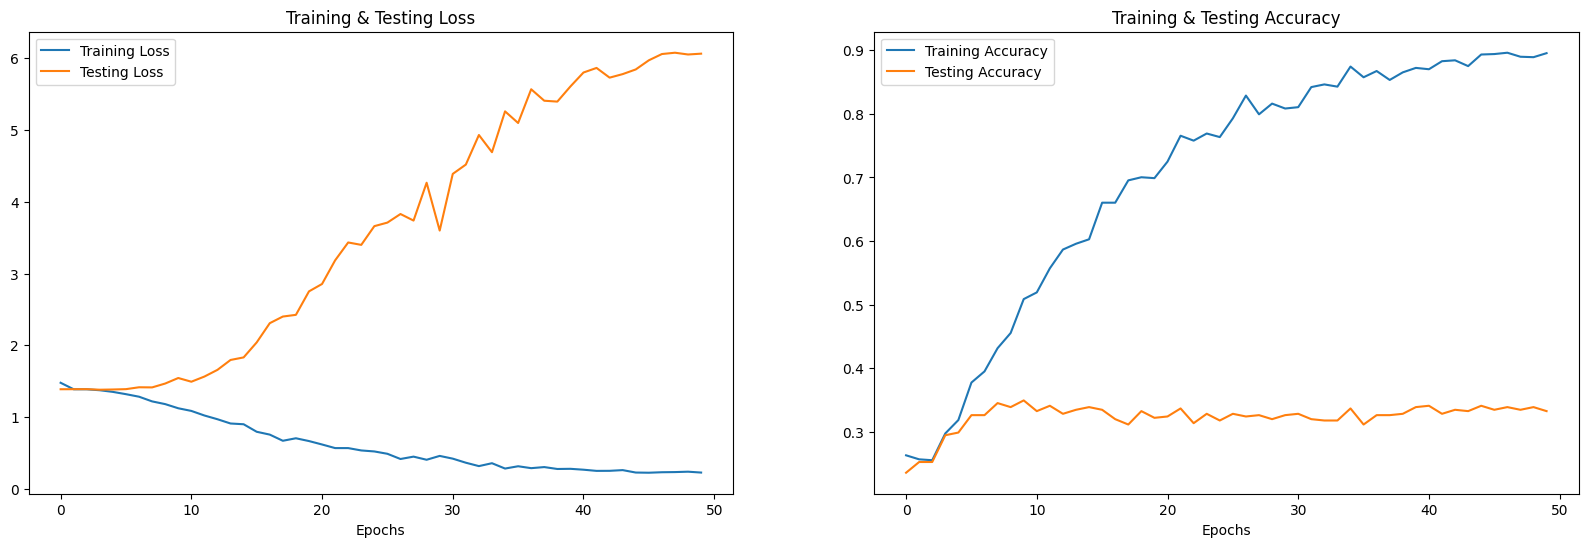

In [29]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [30]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

15/15 [==============================] - 4s 264ms/step


In [31]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,joy,disgust
1,surprise,surprise
2,joy,disgust
3,anger,joy
4,joy,disgust
5,joy,joy
6,joy,disgust
7,disgust,surprise
8,anger,joy
9,surprise,joy


In [34]:
import seaborn as sns

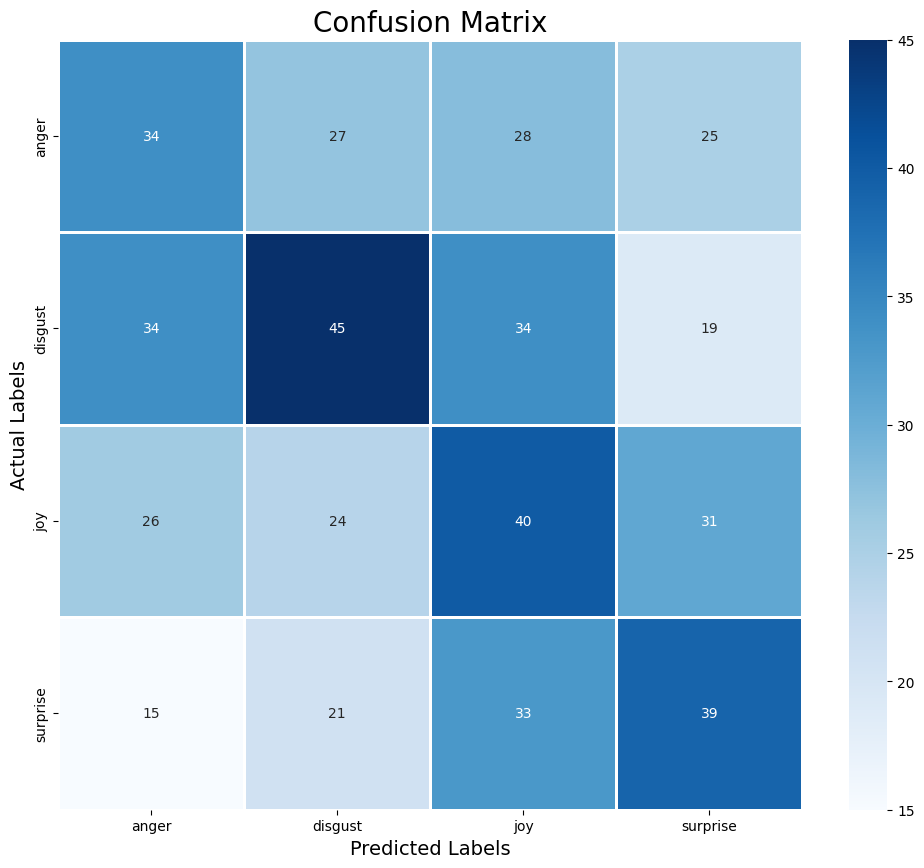

In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.31      0.30      0.30       114
     disgust       0.38      0.34      0.36       132
         joy       0.30      0.33      0.31       121
    surprise       0.34      0.36      0.35       108

    accuracy                           0.33       475
   macro avg       0.33      0.33      0.33       475
weighted avg       0.34      0.33      0.33       475

